<a href="https://colab.research.google.com/github/FarwaSiddiqui/ECG-based-Arrythmia-detection/blob/main/CNN1d_Experiment_01_incartdbipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing of INCARTdb dabase for the Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Necessary Libraries


In [ ]:
pip install optuna


In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
import os
from tensorflow.keras.models import load_model
import json
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score


import optuna
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Arrytmiadetection/data')
print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/Arrytmiadetection/data


In [ ]:
!pip install wfdb

# ***This is about incartdb dataset***

In [ ]:
import wfdb

# Path to the record (excluding extension)

record_path = 'incartdb/1.0.0/I01'

# Read the header and signal
record = wfdb.rdrecord(record_path)
print("Header (.hea) information:")
print(record.__dict__)


Header (.hea) information:
{'record_name': 'I01', 'n_sig': 12, 'fs': 257, 'counter_freq': None, 'base_counter': None, 'sig_len': 462600, 'base_time': None, 'base_date': None, 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension', 'patient 1', 'PVCs, noise'], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[ 3.79411765,  1.49346405, -0.30392157, ..., -4.07189542,
         1.65359477,  6.44444444],
       [ 3.75816993,  1.47712418, -0.28431373, ..., -4.05228758,
         1.66013072,  6.44771242],
       [ 3.76470588,  1.49673203, -0.27124183, ..., -4.01633987,
         1.67320261,  6.44771242],
       ...,
       [ 0.54901961,  4.60784314,  6.05555556, ..., -0.29084967,
         4.88562092,  0.61764706],
       [ 0.49673203,  4.59150327,  6.09150327, ..., -0.34313725,
         4.86928105,  0.57843137],
       [ 0.40849673,  4.57189542,  6.16013072, ..., -0.32679739,
         4.87581699,  0.

In [ ]:
# Read annotation (from .atr file)
annotation = wfdb.rdann(record_path, 'atr')
print("Annotation (.atr) sample indices and labels:")
print(list(zip(annotation.sample[:20], annotation.symbol[:20])))  # Print first 20 annotations


Annotation (.atr) sample indices and labels:
[(np.int64(114), 'N'), (np.int64(277), 'N'), (np.int64(442), 'N'), (np.int64(608), 'N'), (np.int64(710), 'V'), (np.int64(941), 'N'), (np.int64(1106), 'N'), (np.int64(1269), 'N'), (np.int64(1435), 'N'), (np.int64(1596), 'N'), (np.int64(1756), 'N'), (np.int64(1914), 'N'), (np.int64(2076), 'N'), (np.int64(2237), 'N'), (np.int64(2393), 'N'), (np.int64(2557), 'N'), (np.int64(2656), 'V'), (np.int64(2885), 'N'), (np.int64(3042), 'N'), (np.int64(3203), 'N')]


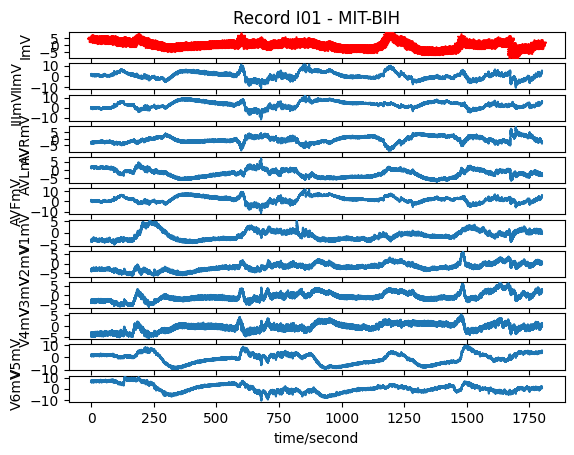

In [ ]:
# Plot signal with annotation marks
wfdb.plot_wfdb(record=record, annotation=annotation, title='Record I01 - MIT-BIH')


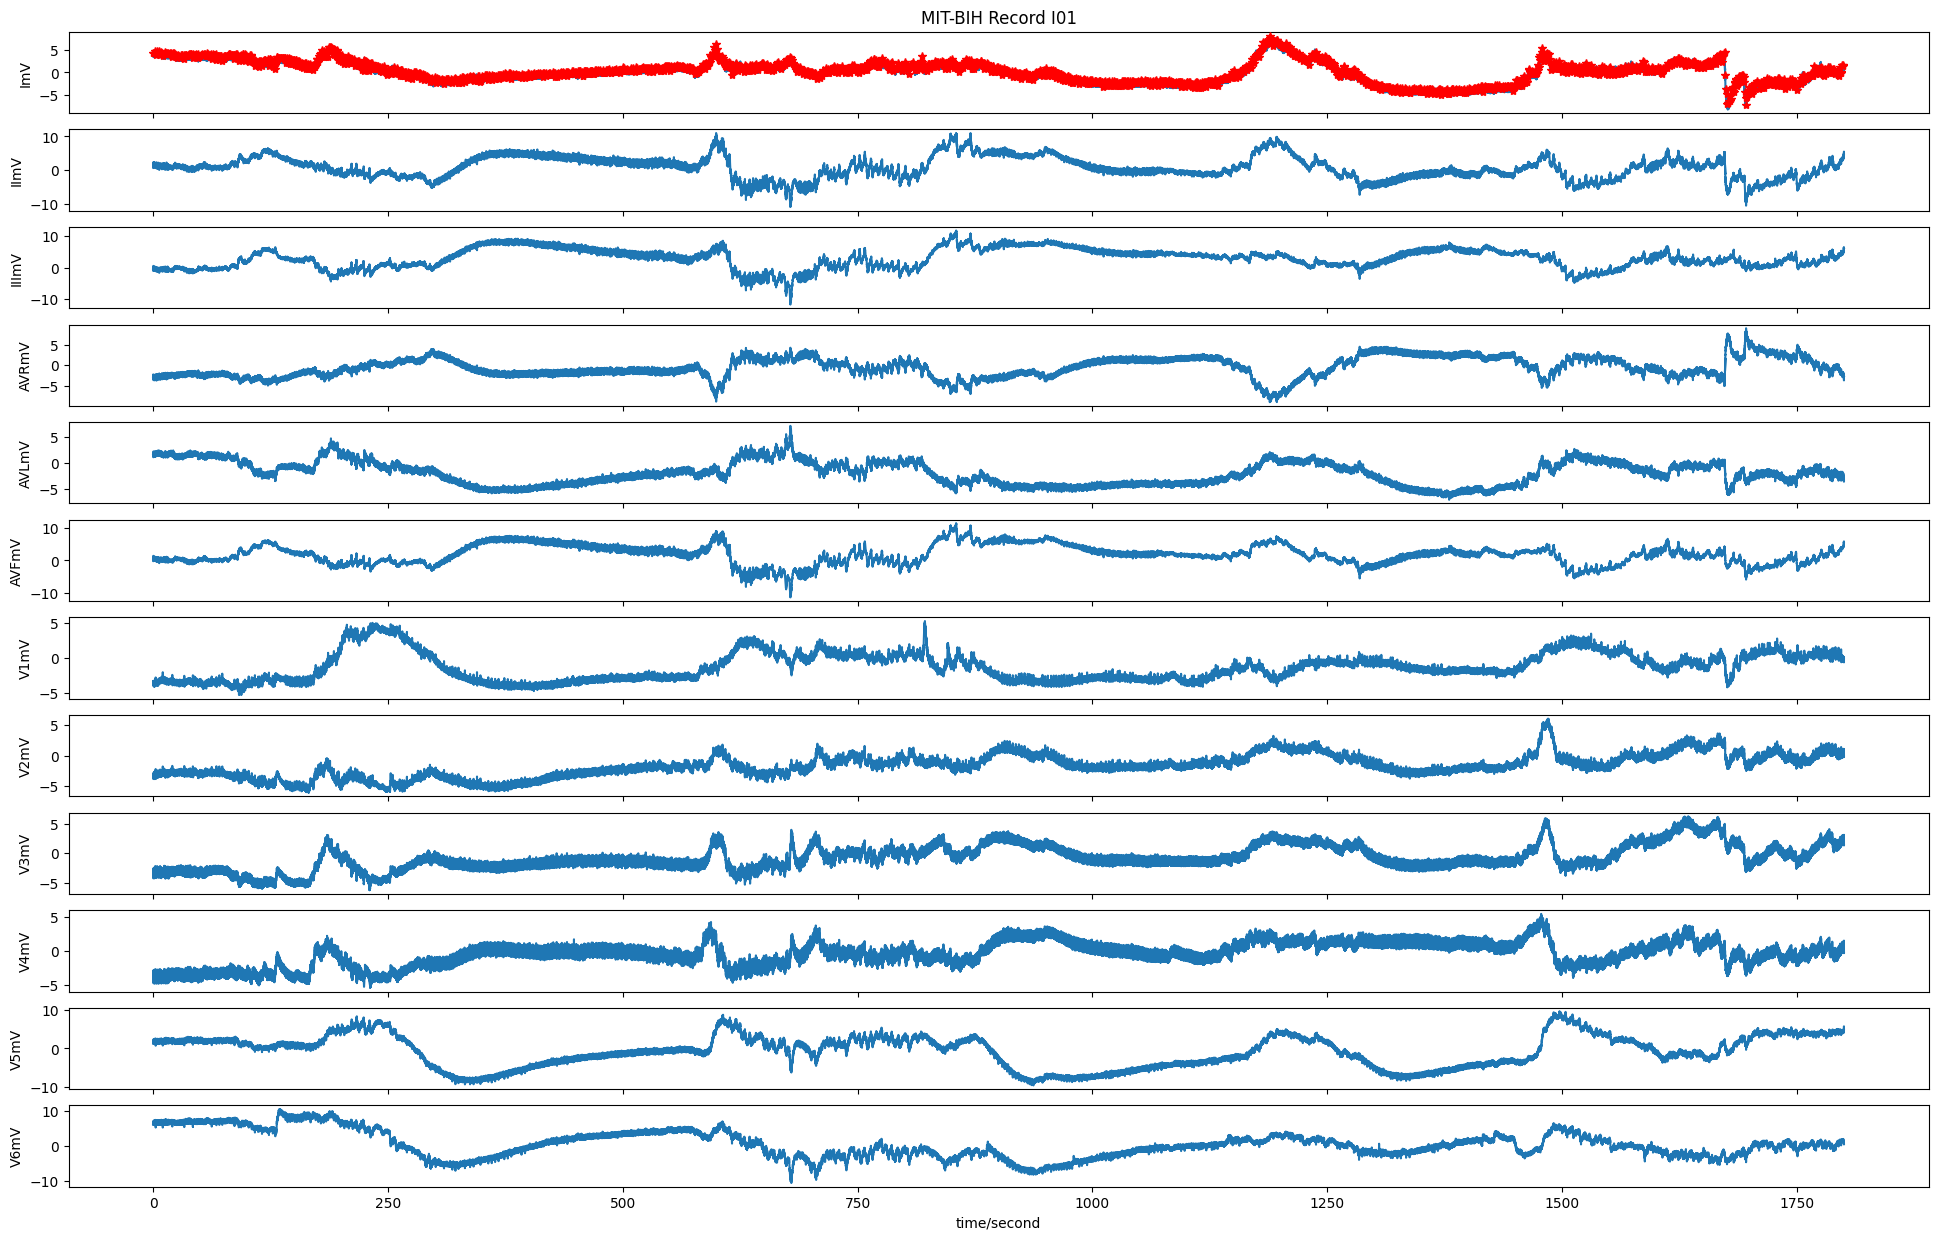

In [ ]:
wfdb.plot_wfdb(
    record=record,
    annotation=annotation,
    title='MIT-BIH Record I01',
    figsize=(24, 15)  # Width x Height in inches
)

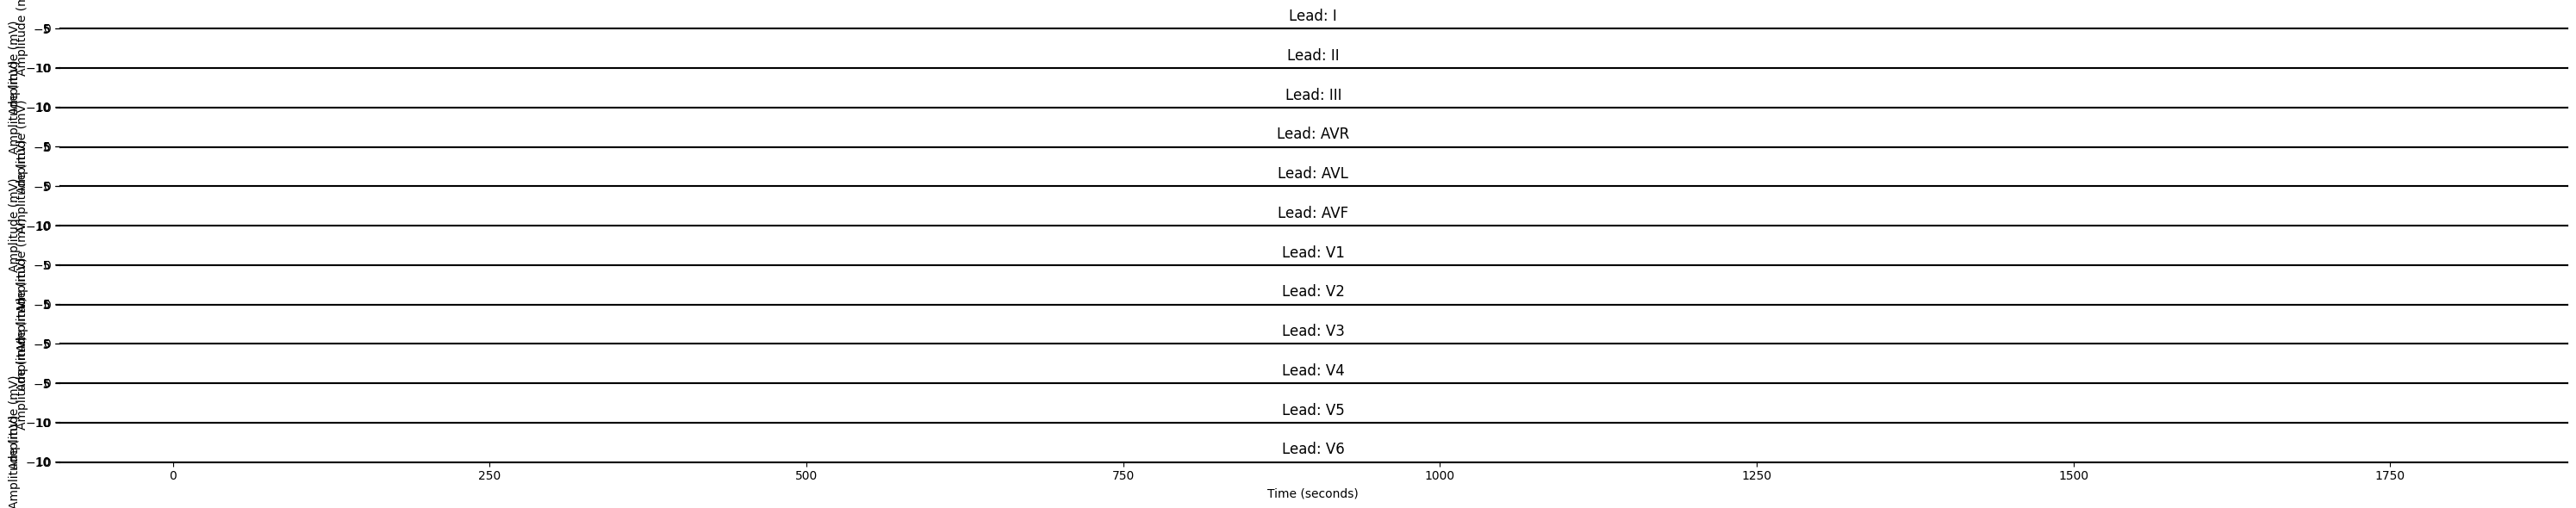

In [ ]:
import wfdb
import matplotlib.pyplot as plt

# Load the record (no need for annotation unless you want it)
record_path = 'incartdb/1.0.0/I01'
record = wfdb.rdrecord(record_path)

# Extract signal data and metadata
signal = record.p_signal
leads = record.sig_name
num_leads = len(leads)
signal_length = signal.shape[0]
fs = record.fs  # Sampling frequency (360 Hz)

# Create time axis in seconds
time = [i / fs for i in range(signal_length)]

# Plot each lead on a separate subplot
plt.figure(figsize=(30, 6))  # Wide and readable

for i in range(num_leads):
    plt.subplot(num_leads, 1, i + 1)
    plt.plot(time, signal[:, i], linewidth=0.6)
    plt.title(f"Lead: {leads[i]}")
    plt.ylabel("Amplitude (mV)")
    if i == num_leads - 1:
        plt.xlabel("Time (seconds)")
    else:
        plt.xticks([])  # Hide x-axis ticks for all but last

    plt.grid(True)

plt.tight_layout()
plt.show()


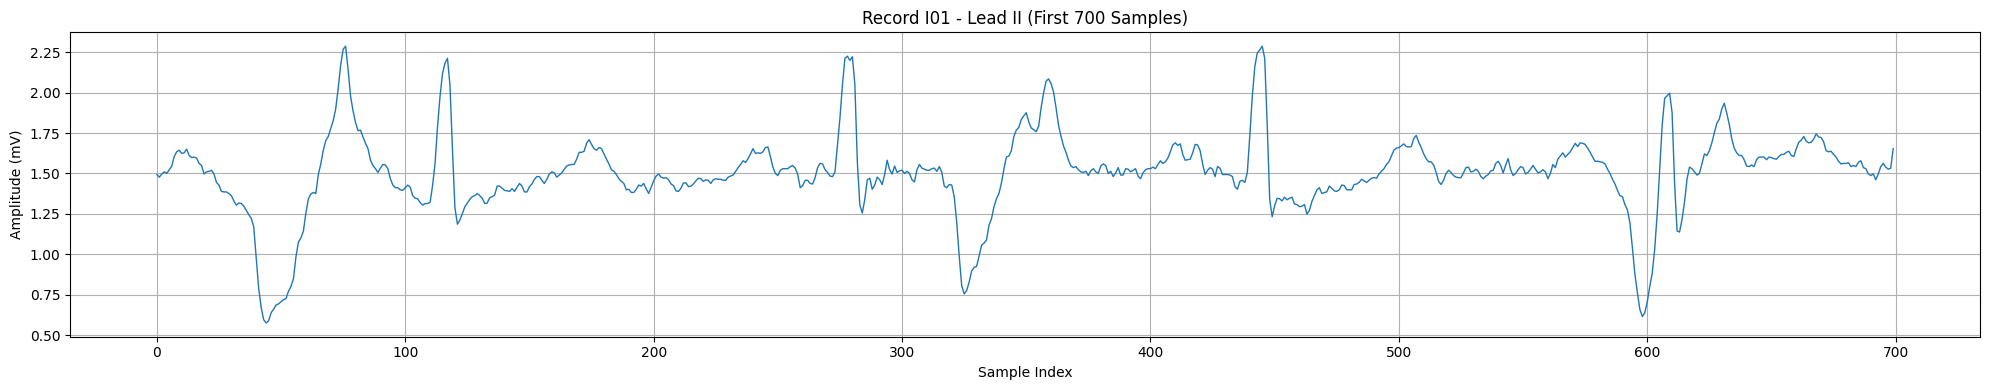

In [ ]:
import wfdb
import matplotlib.pyplot as plt

# Load record 101
record_path = 'incartdb/1.0.0/I01'
record = wfdb.rdrecord(record_path)

# Extract signal and lead names
signal = record.p_signal
leads = record.sig_name

# Choose Lead MLII (usually at index 0)
lead_index = leads.index('II')  # Confirm MLII is present
lead_signal = signal[:, lead_index]

# Plot the first 700 samples of MLII
plt.figure(figsize=(20, 4))
plt.plot(lead_signal[:700], linewidth=1)
plt.title("Record I01 - Lead II (First 700 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Raw signal array (2D NumPy array: shape = [n_samples, n_channels])
signal_data = record.p_signal
print("Signal shape:", signal_data.shape)

# Print first 10 samples of both channels
print("First 10 samples:")
print(signal_data[:10])


Signal shape: (462600, 12)
First 10 samples:
[[ 3.79411765  1.49346405 -0.30392157 -2.77777778  1.52614379  0.58496732
  -3.4379085  -3.33333333 -3.41503268 -4.07189542  1.65359477  6.44444444]
 [ 3.75816993  1.47712418 -0.28431373 -2.75163399  1.5         0.58823529
  -3.45098039 -3.32026144 -3.38888889 -4.05228758  1.66013072  6.44771242]
 [ 3.76470588  1.49673203 -0.27124183 -2.76470588  1.49673203  0.60457516
  -3.45424837 -3.29084967 -3.3496732  -4.01633987  1.67320261  6.44771242]
 [ 3.84313725  1.50980392 -0.33660131 -2.81045752  1.56862745  0.57843137
  -3.47058824 -3.27777778 -3.32352941 -4.          1.66339869  6.43137255]
 [ 3.81372549  1.5        -0.31699346 -2.79084967  1.54248366  0.58169935
  -3.47385621 -3.25816993 -3.29084967 -3.96405229  1.70261438  6.46732026]
 [ 3.7745098   1.52287582 -0.25490196 -2.78431373  1.49346405  0.62418301
  -3.45751634 -3.20915033 -3.23529412 -3.91176471  1.76470588  6.52287582]
 [ 3.80392157  1.54575163 -0.26143791 -2.81045752  1.50980392

In [ ]:
import wfdb
from scipy.signal import medfilt
from scipy import stats
import numpy as np
import os

# Path to folder containing INCARTDB WFDB files
data_dir = 'incartdb/1.0.0/'

# Automatically read all record names from .hea files
records = [f.replace('.hea', '') for f in os.listdir(data_dir) if f.endswith('.hea')]
records.sort()  # Optional: sort alphabetically

print("Found records:", records)

# Settings
window_size = 180  # 180 before and after = 360 samples
maximum_counting = 10000
classes = ['N', 'L', 'R', 'A', 'V']
count_classes = [0] * len(classes)

X = []
y = []

# Process each record
for rec in records:
    try:
        rec_path = os.path.join(data_dir, rec)
        record = wfdb.rdrecord(rec_path)
        annotation = wfdb.rdann(rec_path, 'atr')

        # Use MLII lead (or adjust based on available signals)
        signal = record.p_signal[:, 0]
        signal = medfilt(signal, kernel_size=5)
        signal = stats.zscore(signal)

        for i, pos in enumerate(annotation.sample):
            if pos > window_size and pos < len(signal) - window_size:
                label = annotation.symbol[i]
                if label in classes:
                    idx = classes.index(label)
                    if count_classes[idx] < maximum_counting:
                        beat = signal[pos - window_size: pos + window_size]
                        X.append(beat)
                        y.append(idx)
                        count_classes[idx] += 1

        print(f"✓ Processed record {rec}")

    except Exception as e:
        print(f"⚠️ Error processing record {rec}: {e}")

# Final output
print("✅ Beat extraction complete!")
print("Shape of X:", np.shape(X))
print("Shape of y:", np.shape(y))
print("Class counts:", dict(zip(classes, count_classes)))


Found records: ['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45', 'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54', 'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72', 'I73', 'I74', 'I75']
✓ Processed record I01
✓ Processed record I02
✓ Processed record I03
✓ Processed record I04
✓ Processed record I05
✓ Processed record I06
✓ Processed record I07
✓ Processed record I08
✓ Processed record I09
✓ Processed record I10
✓ Processed record I11
✓ Processed record I12
✓ Processed record I13
✓ Processed record I14
✓ Processed record I15
✓ Processed record I16
✓ Processed record I17
✓ Processed record I18
✓ Processed record I19
✓ Processed record I20

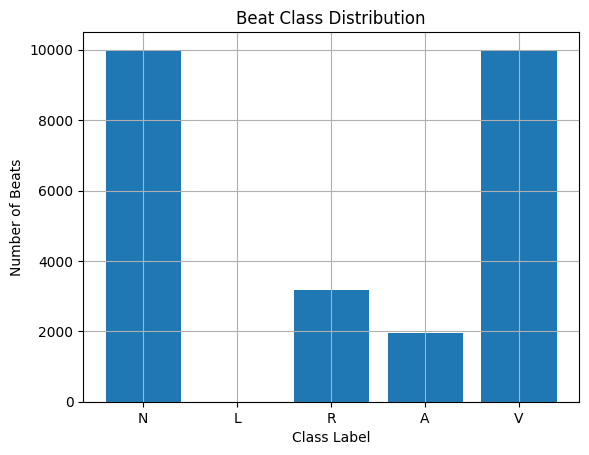

In [ ]:
import matplotlib.pyplot as plt

classes = ['N', 'L', 'R', 'A', 'V']
plt.bar(classes, [10000, 0, 3172, 1942, 10000])
plt.title("Beat Class Distribution")
plt.ylabel("Number of Beats")
plt.xlabel("Class Label")
plt.grid(True)
plt.show()


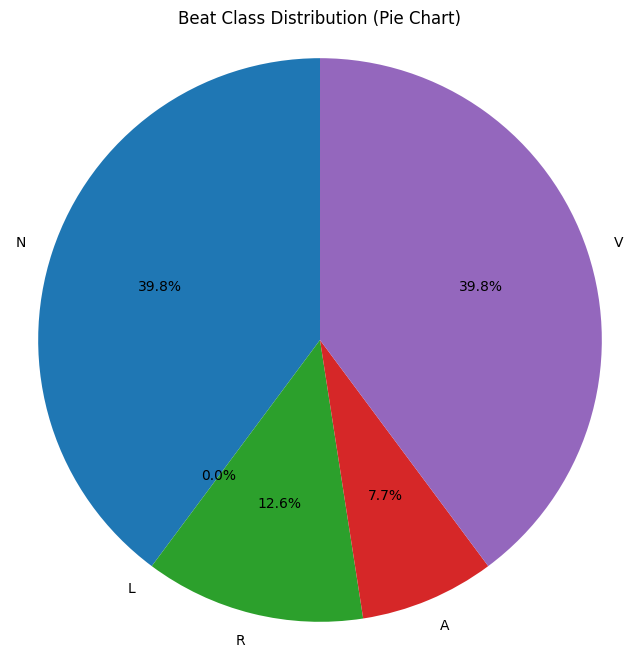

In [ ]:
import matplotlib.pyplot as plt

# Class labels and counts
classes = ['N', 'L', 'R', 'A', 'V']
counts = [10000, 0, 3172, 1942, 10000]

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
plt.title("Beat Class Distribution (Pie Chart)")
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()


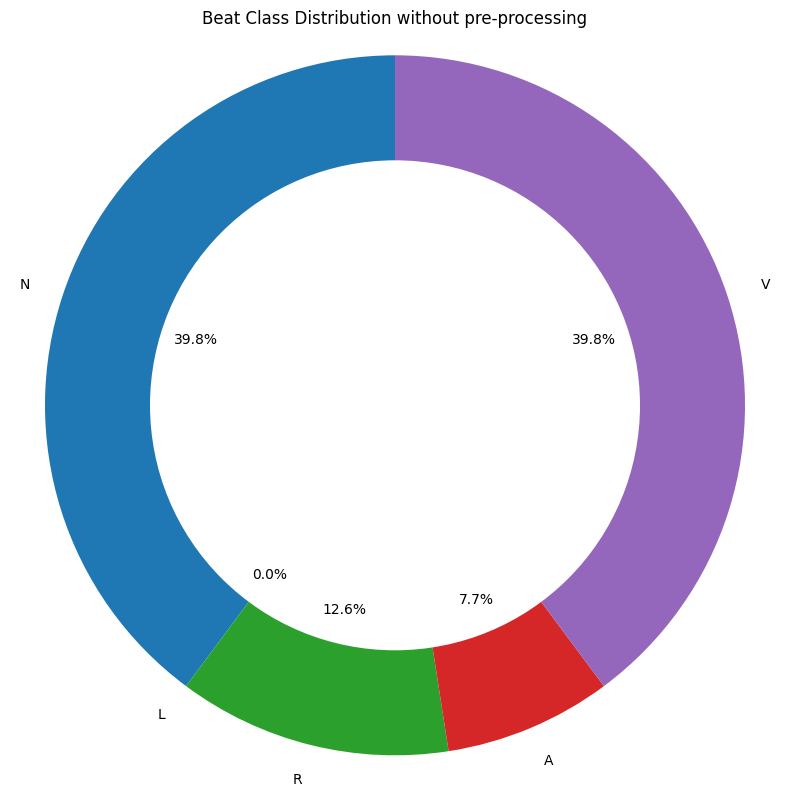

In [ ]:


# Create figure and pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=classes,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops=dict(width=0.4)  # This creates the "donut" effect
)

# Add a white circle at the center (optional for full control)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures the pie is drawn as a circle
ax.axis('equal')
plt.title("Beat Class Distribution without pre-processing")
plt.tight_layout()
plt.show()


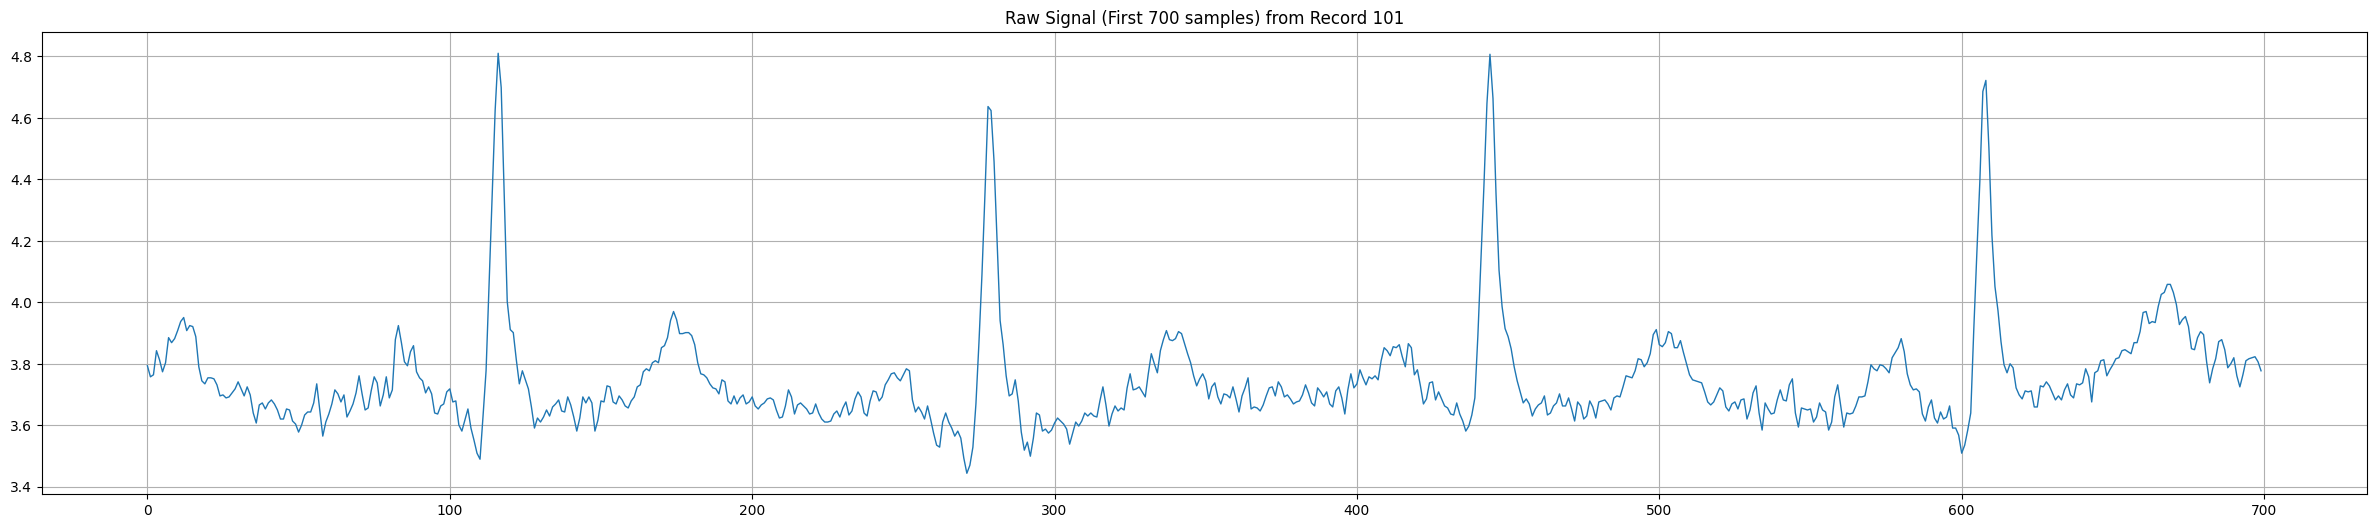

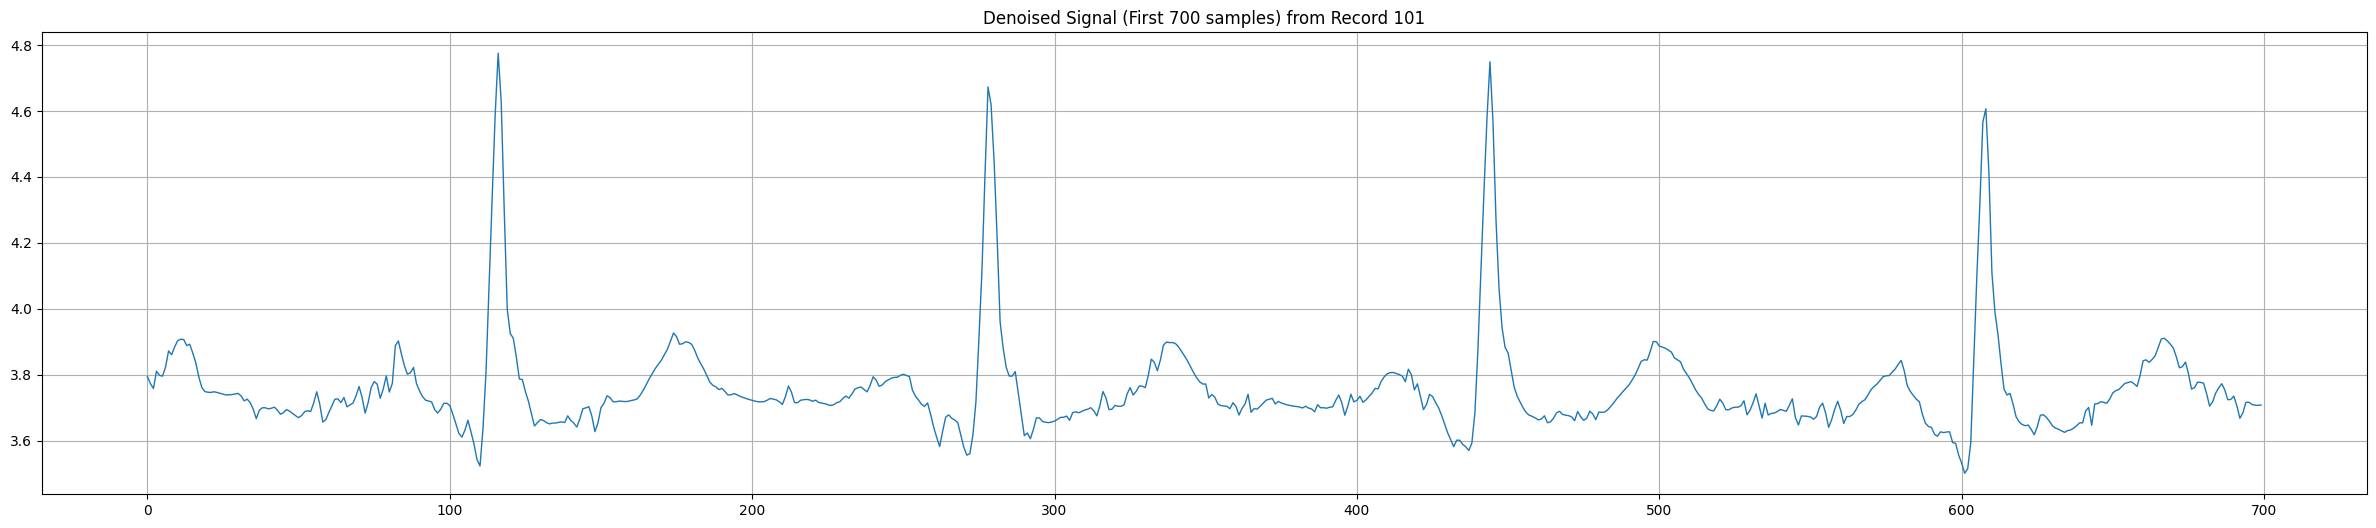

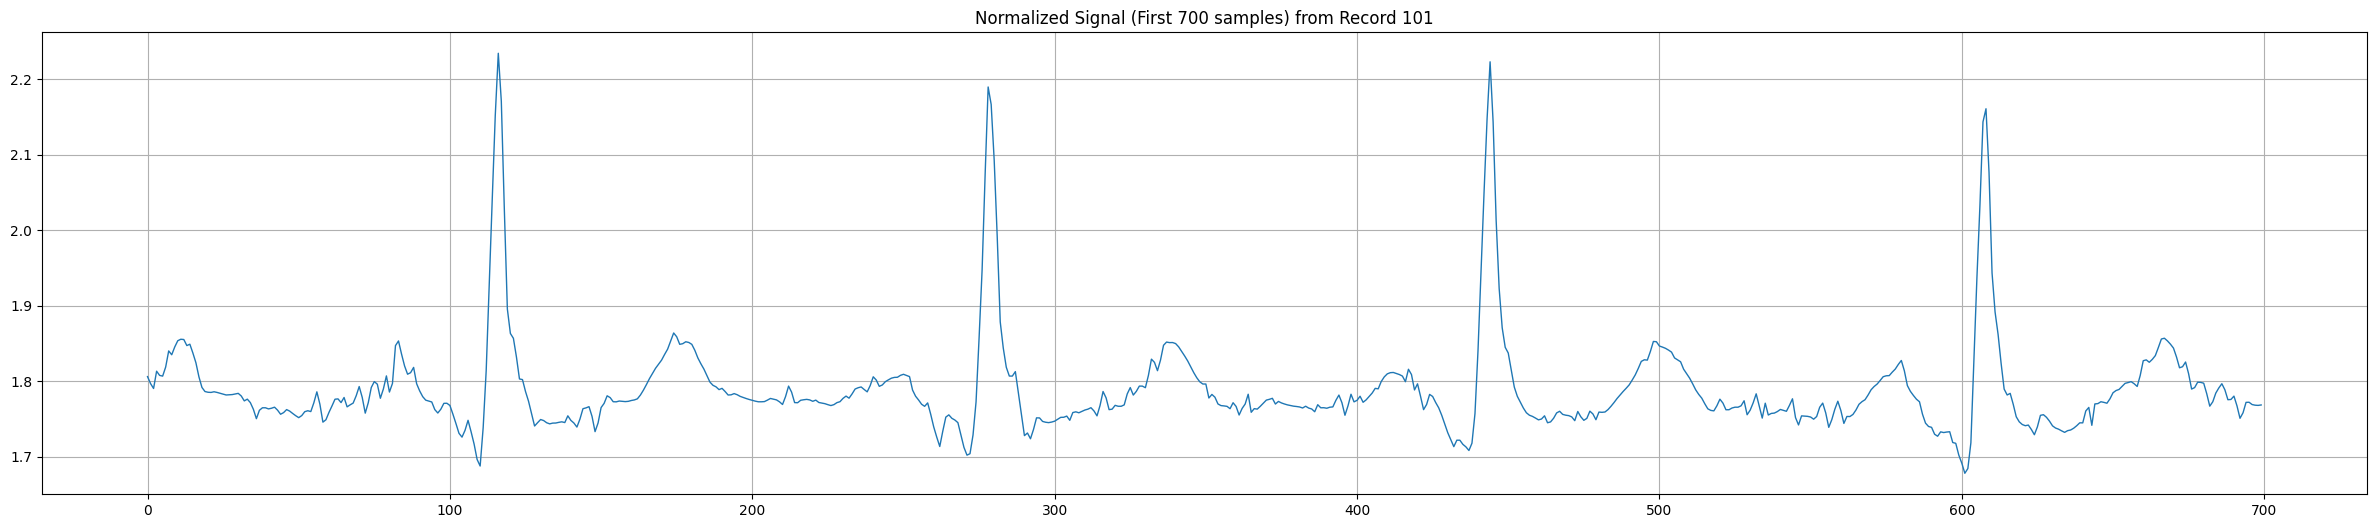

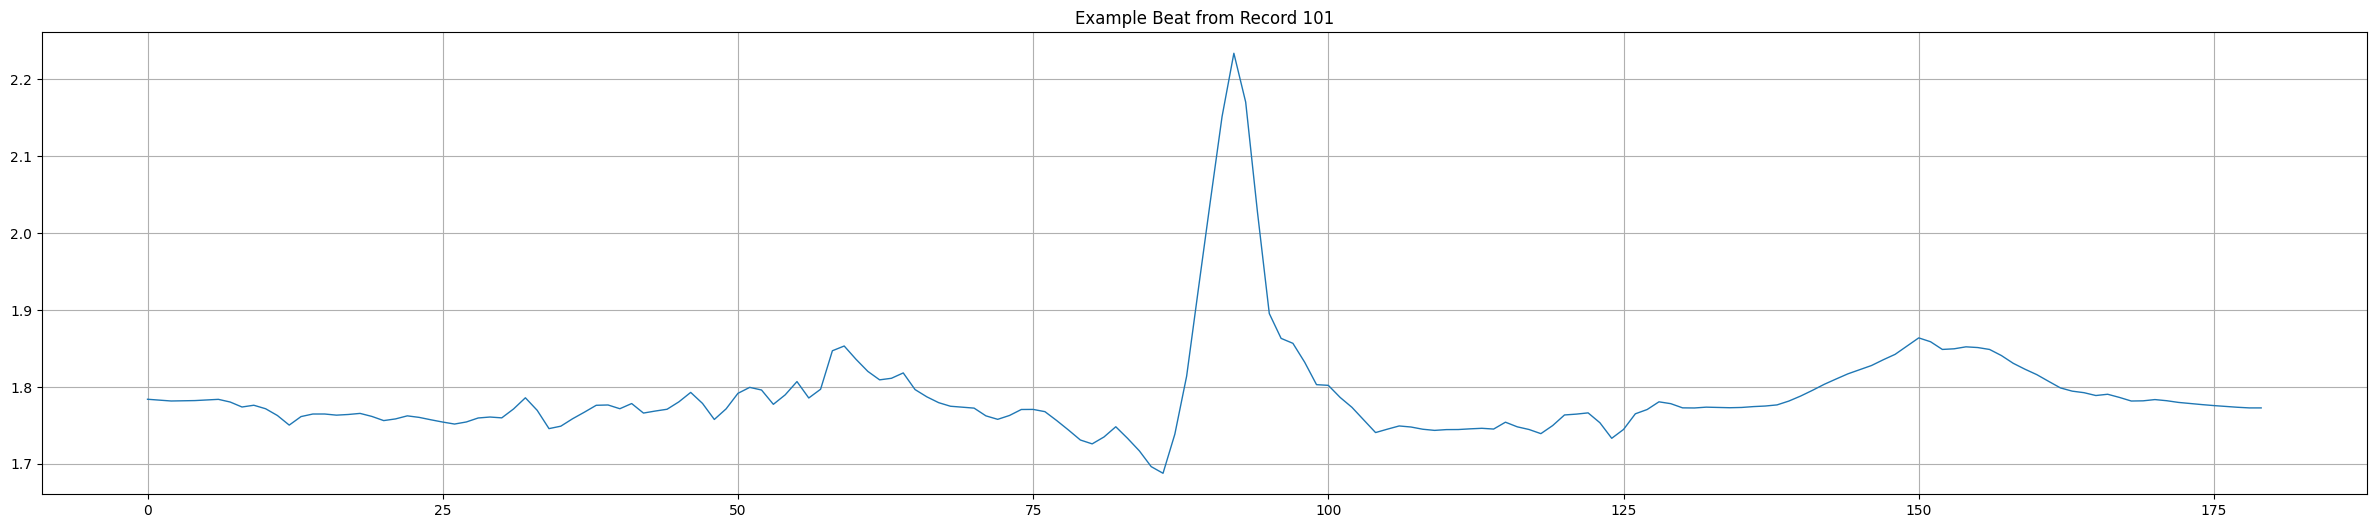

✓ Processed record I01
✓ Processed record I02
✓ Processed record I03
✓ Processed record I04
✓ Processed record I05
✓ Processed record I06
✓ Processed record I07
✓ Processed record I08
✓ Processed record I09
✓ Processed record I10
✓ Processed record I11
✓ Processed record I12
✓ Processed record I13
✓ Processed record I14
✓ Processed record I15
✓ Processed record I16
✓ Processed record I17
✓ Processed record I18
✓ Processed record I19
✓ Processed record I20
✓ Processed record I21
✓ Processed record I22
✓ Processed record I23
✓ Processed record I24
✓ Processed record I25
✓ Processed record I26
✓ Processed record I27
✓ Processed record I28
✓ Processed record I29
✓ Processed record I30
✓ Processed record I31
✓ Processed record I32
✓ Processed record I33
✓ Processed record I34
✓ Processed record I35
✓ Processed record I36
✓ Processed record I37
✓ Processed record I38
✓ Processed record I39
✓ Processed record I40
✓ Processed record I41
✓ Processed record I42
✓ Processed record I43
✓ Processed

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pywt



# Path to MIT-BIH WFDB data
base_path = 'incartdb/1.0.0/'

# Class labels of interest
classes = ['N', 'L', 'R', 'A', 'V']
count_classes = [0] * len(classes)

# Windowing and output lists
window_size = 90  # for 180-sample beat
X = []
y = []

# ---- Wavelet Denoising ----
def denoise(signal):
    wavelet = 'sym4'
    coeffs = pywt.wavedec(signal, wavelet, level=pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len))
    threshold = 0.04
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))
    return pywt.waverec(coeffs, wavelet)[:len(signal)]


# ---- Loop Through Each Record ----
for r, rec in enumerate(records):
    try:
        rec_path = base_path + rec
        record = wfdb.rdrecord(rec_path)
        annotation = wfdb.rdann(rec_path, 'atr')

        # Get MLII lead (usually index 0)
        signal = record.p_signal[:, 0]

        # Plot raw signal for record 101
        if rec == 'I01':
            plt.title("Raw Signal (First 700 samples) from Record 101")
            plt.plot(signal[:700])
            plt.show()

        # Denoise
        signal = denoise(signal)

        if rec == 'I01':
            plt.title("Denoised Signal (First 700 samples) from Record 101")
            plt.plot(signal[:700])
            plt.show()

        # Z-score normalize
        signal = stats.zscore(signal)

        if rec == 'I01':
            plt.title("Normalized Signal (First 700 samples) from Record 101")
            plt.plot(signal[:700])
            plt.show()

        # Extract beat windows from annotations
        example_beat_printed = False
        for i, pos in enumerate(annotation.sample):
            if pos < window_size or pos > (len(signal) - window_size):
                continue

            label = annotation.symbol[i]
            if label in classes:
                class_index = classes.index(label)
                count_classes[class_index] += 1

                beat = signal[pos - window_size:pos + window_size]

                # Plot one example beat from record 101
                if rec == 'I01' and not example_beat_printed:
                    plt.title("Example Beat from Record 101")
                    plt.plot(beat)
                    plt.show()
                    example_beat_printed = True

                X.append(beat)
                y.append(class_index)

        print(f"✓ Processed record {rec}")

    except Exception as e:
        print(f"⚠️ Error processing record {rec}: {e}")

# Final shape
print("✅ Beat extraction complete!")
print("Shape of X:", np.shape(X))
print("Shape of y:", np.shape(y))
print("Class counts:", dict(zip(classes, count_classes)))


In [ ]:
import numpy as np

np.save('X_incartdb_360.npy', np.array(X))
np.save('y_incartdb_360.npy', np.array(y))

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [ ]:
import pywt
import numpy as np

def denoise(signal):
    """
    Denoises an ECG signal using wavelet decomposition and thresholding.

    Parameters:
    - signal: 1D NumPy array of ECG values (e.g., from p_signal[:, 0])

    Returns:
    - datarec: The denoised signal (same length as input)
    """
    wavelet = 'sym4'
    w = pywt.Wavelet(wavelet)

    # Determine the maximum decomposition level
    maxlev = pywt.dwt_max_level(len(signal), w.dec_len)

    # Decompose the signal
    coeffs = pywt.wavedec(signal, wavelet, level=maxlev)

    # Apply soft thresholding to detail coefficients
    threshold = 0.04
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))

    # Reconstruct the denoised signal
    datarec = pywt.waverec(coeffs, wavelet)

    # Ensure the reconstructed signal matches the original length
    return datarec[:len(signal)]


In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(175479, 181)


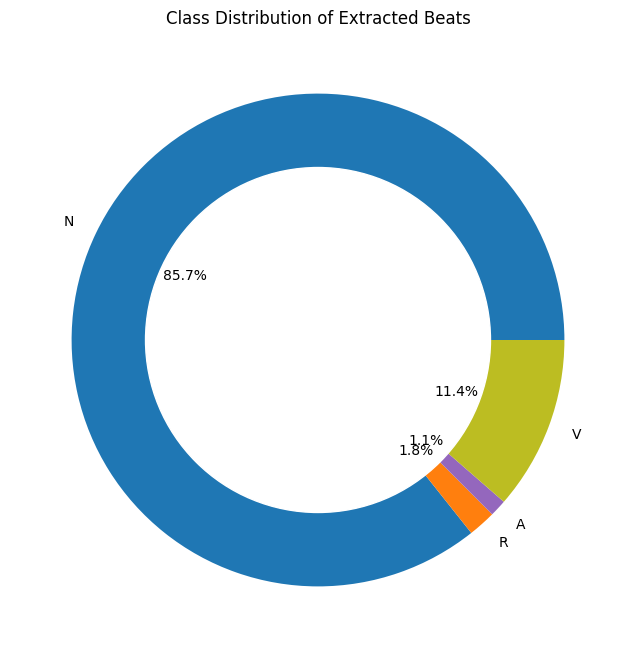

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract signal and label from the (181,) array
X_arr = np.array(X)
X_data = X_arr[:, :-1]
y_labels = X_arr[:, -1].astype(int)

# Count labels
per_class = pd.Series(y_labels).value_counts().sort_index()

# Class label mapping
labels = ['N', 'L', 'R', 'A', 'V']
per_class.index = [labels[i] for i in per_class.index]

# Donut chart
plt.figure(figsize=(8, 8))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=per_class.index, autopct='%1.1f%%',
        colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Class Distribution of Extracted Beats")
plt.show()


In [ ]:
import numpy as np

# Load the saved data
X = np.load('X_incartdb_360.npy', allow_pickle=True)
y = np.load('y_incartdb_360.npy', allow_pickle=True)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (175479, 180)
y shape: (175479,)


In [ ]:
from sklearn.utils import resample

dfs_to_concat = []

for class_label, seed in zip([0, 1, 2, 3, 4], [42, 122, 123, 124, 125]):
    df_class = X_train_df[X_train_df[X_train_df.shape[1]-1] == class_label]
    if len(df_class) > 0:
        df_resampled = resample(df_class, replace=True, n_samples=3000, random_state=seed)
        dfs_to_concat.append(df_resampled)
    else:
        print(f"⚠️ No samples found for class {class_label}. Skipping.")

X_train_df_balanced = pd.concat(dfs_to_concat)


⚠️ No samples found for class 1. Skipping.


In [ ]:
rec_path = 'incartdb/1.0.0/I01'
ann = wfdb.rdann(rec_path, 'atr')
print(set(ann.symbol))  # Show all unique labels


{'V', 'N'}


Summary:
This dataset is slightly different from the MIT_BIH database. Its a 12 lead datset from which we have extracted lead-II for the arrythmia detection.
Here the class 'L' is totally missing from the dataset. We need to check methods of class balancing and also have to test this data set on pre-trained model on MIT_BIH dataset.